# Runs analysis on Cindy's data

In [1]:
import os
import pandas as pd
import re
import numpy as np
import itertools
import configparser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from utils import RegressionModel, train_model, plot_results

tqdm.pandas()

sns.set_theme()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']
MAPBOX_TOKEN = config['ACCESS TOKENS']['MAPBOX']

exp_dir = os.path.join(DATA_DIR, 'cindy_experiments')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dhs_df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))
interventions_df = pd.read_csv(os.path.join(exp_dir, 'interim/interventions.csv'))
interventions_dhs_link_df = pd.read_csv(os.path.join(exp_dir, 'interim/intervention_dhs_link.csv'))

In [3]:
RANDOM_STATE = 42
N_COMPONENTS = 232

# Set seeds
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

embeddings = np.load(os.path.join(DATA_DIR, 'ssl4eo_resnet50.npy'))

assert embeddings.shape[0] == dhs_df.shape[0], 'Mismatch between embeddings and metadata rows.'

X = embeddings

# Cheat by doing rescaling and PCA on the whole set
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=N_COMPONENTS)
X = pca.fit_transform(X)

Y = dhs_df['iwi'].values / 100.0 # Scale IWI to [0, 1]
Y = Y.clip(0, 1)

X = torch.tensor(X, dtype=torch.float).to(device)
Y = torch.tensor(Y, dtype=torch.float).to(device)

X_upstream, X_downstream, y_upstream, y_downstream, df_upstream, df_downstream = train_test_split(X, Y, dhs_df, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val, df_train, df_val = train_test_split(X_upstream, y_upstream, df_upstream, test_size=0.2, random_state=RANDOM_STATE)

## Upstream: Train model

 10%|█         | 5238/50000 [00:11<01:37, 458.37it/s]


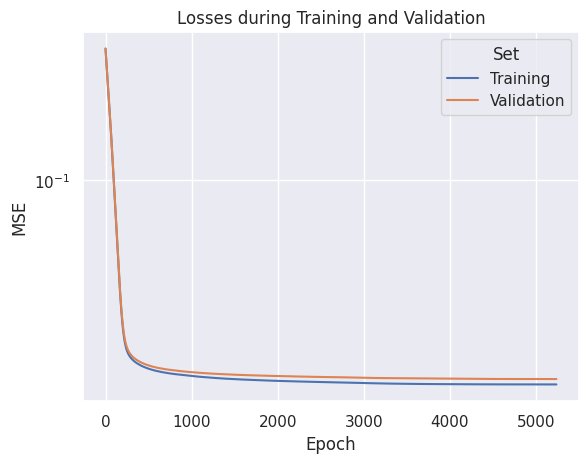

In [4]:
def mse_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    return mse, {'MSE': mse.item()}

mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=1)

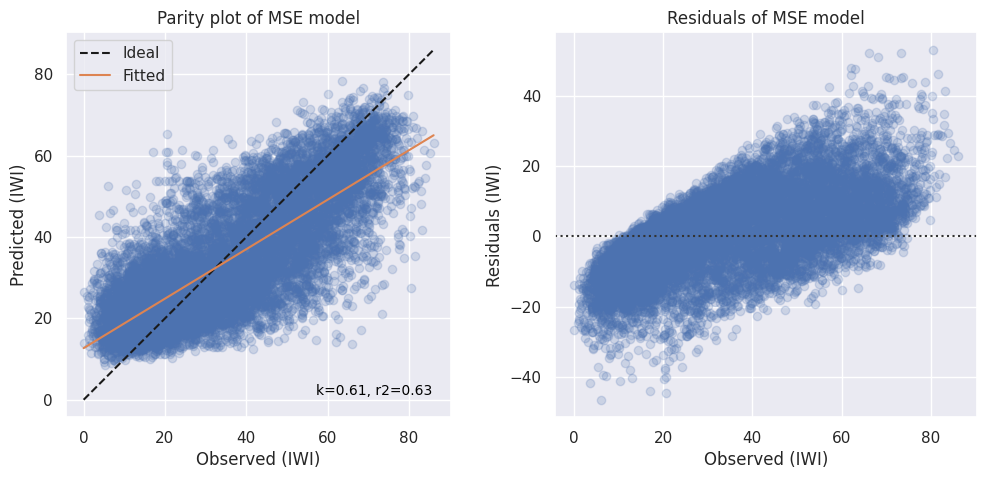

In [5]:
with torch.no_grad():
    mse_pred = mse_model(X_downstream)
    
plot_results(100*y_downstream, 100*mse_pred, 'MSE model')

In [6]:
mse_predictions = 100 * mse_pred.cpu().numpy()
df_downstream['iwi_hat'] = mse_predictions

In [7]:
with torch.no_grad():
    val_predictions = mse_model(X_val).cpu().numpy()
    val_targets = y_val.cpu().numpy()
    val_predictions = val_predictions * 100
    val_targets = val_targets * 100

Get estimates for $k$ and $m$ with LCC

In [8]:
from sklearn.linear_model import LinearRegression

lcc_regressor = LinearRegression()
lcc_regressor.fit(val_targets.reshape(-1, 1), val_predictions)

k = lcc_regressor.coef_[0]
m = lcc_regressor.intercept_
print(f'Estimated slope (k): {k:.4f}')
print(f'Estimated intercept (m): {m:.4f}')

Estimated slope (k): 0.6036
Estimated intercept (m): 12.6851


Get prediction scores for Tweedie's correction

In [ ]:
res_std = (val_predictions - val_targets).std()

print('Var(Y - Y-hat):', res_std)

Var(Y - Y-hat): 11.704947


In [14]:
with torch.no_grad():
    train_predictions = mse_model(X_train).cpu().numpy()
    train_targets = y_train.cpu().numpy()
    train_predictions = train_predictions * 100
    train_targets = train_targets * 100

train_res_std = (train_predictions - train_targets).std()

print('Var(Y - Y-hat):', res_std)
print('Var(Y_train - Y_train_hat):', train_res_std)

Var(Y - Y-hat): 11.704947
Var(Y_train - Y_train_hat): 11.398301


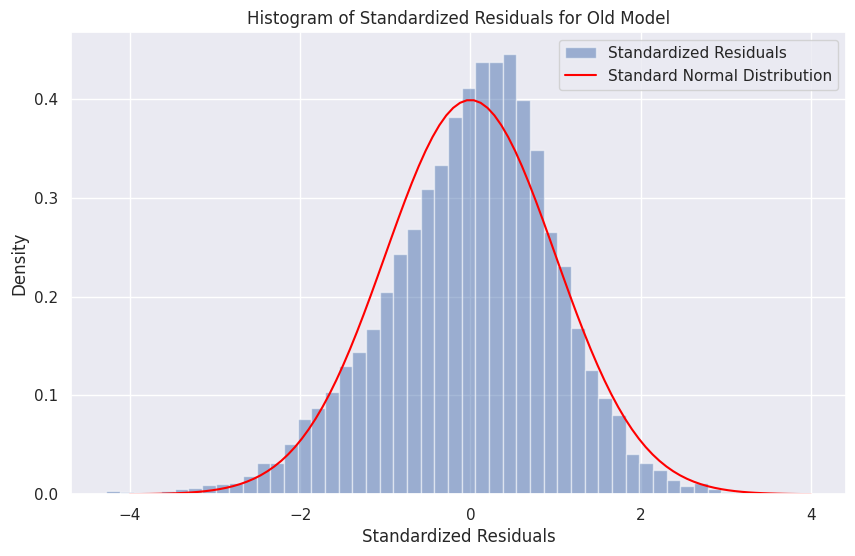

In [13]:
res = (val_predictions - val_targets)
norm_res = (res - res.mean()) / res.std()

# Plot histogram of residuals compared to normal distribution
plt.figure(figsize=(10, 6))
plt.hist(norm_res, bins=50, density=True, alpha=0.5, label='Standardized Residuals')
x = np.linspace(-4, 4, 100)
plt.plot(x, np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi), label='Standard Normal Distribution', color='red')
plt.title('Histogram of Standardized Residuals for Old Model')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

In [10]:
from scipy.stats import gaussian_kde

pred_kde = gaussian_kde(val_predictions)

def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

prediction_scores = np.array([score_function(y, pred_kde) for y in mse_predictions])
df_downstream['prediction_scores'] = prediction_scores

## Downstream: Analyze Intervention

In [32]:
ad_sector_code = 230
funder = 'CH'

intervention_df = interventions_df[(interventions_df['ad_sector_codes'] == ad_sector_code) & (interventions_df['funder'] == funder)]

In [41]:
interventions_dhs_link_df

,project_location_id,cluster_id,years_since_intervention
0,31023_11550981,KE.Baringo.8B.1033,9.412924
1,31023_11550981,KE.Baringo.8B.1034,9.412924
2,31023_11550981,KE.Baringo.8B.1053,9.412924
3,31023_11550981,KE.Baringo.8B.1054,9.495062
4,31023_11550981,KE.Rift Valley.72.1155,1.664647
...,...,...,...
266575,P091077_328649,ET.Affar.81.35,11.589560
266576,P091077_328649,ET.Affar.81.36,11.589560
266577,P091077_328649,ET.Affar.81.37,11.589560
266578,P091077_328649,ET.Affar.81.38,11.589560


In [33]:
intervention_location_ids = intervention_df['project_location_id'].unique()

intervention_dhs_link_df = interventions_dhs_link_df[interventions_dhs_link_df['project_location_id'].isin(intervention_location_ids)]
valid_dhs_clusters = intervention_dhs_link_df[['cluster_id', 'years_since_intervention']].drop_duplicates()

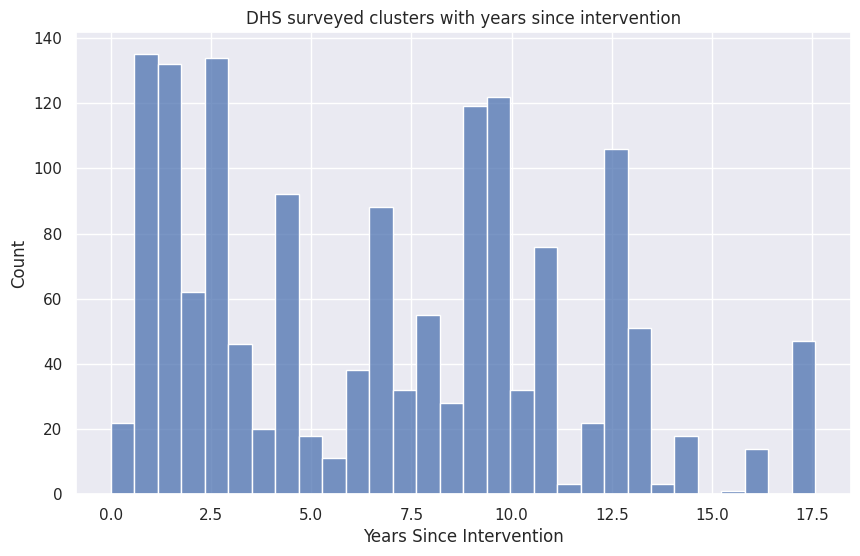

In [34]:
# Plot a histogram of the years since intervention
plt.figure(figsize=(10, 6))
sns.histplot(data=valid_dhs_clusters, x='years_since_intervention', bins=30)
plt.title('DHS surveyed clusters with years since intervention')
plt.xlabel('Years Since Intervention')
plt.ylabel('Count')
plt.show()

In [11]:
valid_dhs_cluster_ids = valid_dhs_clusters[valid_dhs_clusters['years_since_intervention'].between(3, 8)]['cluster_id'].unique()

Get treated clusters

In [12]:
# The maximum and minimum years since the intervention start that we want to include to count as treated
min_years = 3
max_years = 8

valid_dhs_cluster_ids = valid_dhs_clusters[valid_dhs_clusters['years_since_intervention'].between(min_years, max_years)]['cluster_id'].unique()
treated_clusters_ixs = df_test['cluster_id'].isin(valid_dhs_cluster_ids)
treated_df = df_test[treated_clusters_ixs]

Choose control samples as the remaining clusters of surveys that are included in the treatment set

In [13]:
surveys_in_treated_df = treated_df['survey'].unique()
control_clusters_ixs = (df_test['survey'].isin(surveys_in_treated_df)) & ~treated_clusters_ixs
control_df = df_test[control_clusters_ixs]

In [14]:
treated_df.loc[:, 'status'] = 'Treated'
control_df.loc[:, 'status'] = 'Control'

trial_df = pd.concat([treated_df, control_df], axis=0)

trial_df

/local/tmp.4529263/ipykernel_838981/4269914082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_df.loc[:, 'status'] = 'Treated'
/local/tmp.4529263/ipykernel_838981/4269914082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_df.loc[:, 'status'] = 'Control'


,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi,iwi_hat,status
67034,ZM.Southern.71.309,28.743261,-16.510045,True,ZM.Southern,Zambia,Zambia 2018 Standard DHS,9,2018,49.302329,25.565620,Treated
53527,SL.Southern.61.67,-11.661192,8.045746,True,SL.Southern,Sierra Leone,Sierra Leone 2013 Standard DHS,6,2013,17.700776,17.590109,Treated
17596,ET.Addis Ababa.71.108,38.733008,9.032176,False,ET.Addis Ababa,Ethiopia,Ethiopia 2016 Standard DHS,1,2016,52.573040,54.731750,Treated
9696,CM.Yaoundé.71.446,11.478789,3.876906,False,CM.Yaoundé,Cameroon,Cameroon 2018 Standard DHS,8,2018,57.374928,44.718216,Treated
54190,SN.Dakar.61.133,-17.443829,14.747587,False,SN.Dakar,Senegal,Senegal 2010-11 Standard DHS,10,2010,51.936748,63.865997,Treated
...,...,...,...,...,...,...,...,...,...,...,...,...
52459,SL.Eastern.61.184,-10.793172,7.936034,True,SL.Eastern,Sierra Leone,Sierra Leone 2013 Standard DHS,9,2013,15.130794,16.540741,Control
29286,KE.Western.72.1503,34.499054,0.340168,False,KE.Western,Kenya,Kenya 2014 Standard DHS,7,2014,52.372049,32.672527,Control
5525,BU.North.61.43,29.916724,-2.822788,True,BU.North,Burundi,Burundi 2010 Standard DHS,12,2010,10.702361,17.900995,Control
66099,ZM.Eastern.71.191,32.661448,-13.660406,False,ZM.Eastern,Zambia,Zambia 2018 Standard DHS,12,2018,42.934753,38.210892,Control


In [15]:
from mapboxgl.utils import df_to_geojson, create_color_stops
from mapboxgl.viz import CircleViz

# Convert dataframe to GeoJSON
geojson = df_to_geojson(
    trial_df,
    lat='lat',
    lon='lon',
    properties=['status'],
)

# Create color stops for the map
color_stops = [
    ['Treated', 'rgb(256,0,0)'],  # Red for treated
    ['Control', 'rgb(0,0,256)'],  # Blue for control
]
# Create a CircleViz object
viz = CircleViz(
    geojson,
    access_token=MAPBOX_TOKEN,
    color_property='status',
    color_stops=color_stops,
    color_function_type='match',
    radius=5,
    opacity=0.8,
    stroke_color='#000000',
    stroke_width=1,
)
viz.show()

/opt/conda/lib/python3.8/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Get the ATE without any propensity weighting

In [23]:
ate = treated_df['iwi'].mean() - control_df['iwi'].mean()
ate_hat = treated_df['iwi_hat'].mean() - control_df['iwi_hat'].mean()

print(f'ATE: {ate:.4f}')
print(f'ATE hat: {ate_hat:.4f}')

ATE: 14.9277
ATE hat: 14.5609


## Run for all treatments

In [11]:
trials_df = interventions_df[['funder', 'ad_sector_codes']].drop_duplicates().reset_index(drop=True)

ad_sector_names = {
    #Social Infrastructure & Services
    110: "Education",
    120: "Health",
    130: "Population Policies / Programmes and Reproductive Health",
    140: "Water Supply and Sanitation",
    150: "Government and Civil Society",
    160: "Other Social Infrastructure and Services",
    # Economic Infrastructure & Services 
    210: "Transport and Storage",
    220: "Communications",
    230: "Energy Generation and Supply",
    240: "Banking and Financial Services",
    250: "Business and Other Services",
    # Production
    310: "Agriculture, Forestry and Fishing",
    320: "Industry, Mining, Construction",
    330: "Trade and Tourism",
    # Direct Aid
    520: "Developmental Food Aid/Food Security Assistance",
    700: "Emergency Response",
    600: "Action Relating to Debt",
    920: "Support to Non-governmental Organizations (NGOs) and Government Organizations",
    530: "Non-food commodity assistance",
    # Other
    410: "General Environment Protection",
    420: "Women in Development",
    430: "Other Multisector",
    998: "Unallocated / Unspecified"
}

trials_df['ad_sector_names'] = trials_df['ad_sector_codes'].map(ad_sector_names)

trials_df

,funder,ad_sector_codes,ad_sector_names
0,CH,230,Energy Generation and Supply
1,CH,220,Communications
2,CH,210,Transport and Storage
3,CH,110,Education
4,CH,150,Government and Civil Society
5,CH,320,"Industry, Mining, Construction"
6,CH,310,"Agriculture, Forestry and Fishing"
7,CH,120,Health
8,CH,520,Developmental Food Aid/Food Security Assistance
9,CH,140,Water Supply and Sanitation


In [12]:
def get_PPI_ATE(treated_df, control_df, labeled_frac=0.1):
    """
    Calculate the ATE with PPI (Prediction Powered Inference) between treated and control groups.
    """

    # Sample a fraction of the treated and control groups to use as the "fresh" labeled data
    n_samples = len(treated_df) + len(control_df)
    sample_ixs = np.random.choice(np.arange(n_samples), size=int(n_samples * labeled_frac), replace=False)
    treated_sample_ixs = sample_ixs[sample_ixs < len(treated_df)]
    control_sample_ixs = sample_ixs[sample_ixs >= len(treated_df)] - len(treated_df)

    labeled_treated_df = treated_df.iloc[treated_sample_ixs]
    labeled_control_df = control_df.iloc[control_sample_ixs]
    
    # Use the remaining data as unlabeled
    unlabeled_treated_df = treated_df.drop(labeled_treated_df.index)
    unlabeled_control_df = control_df.drop(labeled_control_df.index)

    # Get the biases with the labeled data
    treated_bias = (labeled_treated_df['iwi'] - labeled_treated_df['iwi_hat']).mean()
    control_bias = (labeled_control_df['iwi'] - labeled_control_df['iwi_hat']).mean()

    ppi_ate = (unlabeled_treated_df['iwi_hat'].mean() - unlabeled_control_df['iwi_hat'].mean()) + (treated_bias - control_bias)
    return ppi_ate

In [13]:
def get_ates_of_trial(row, interventions_df, df_test, dhs_df):
    ad_sector_code = row['ad_sector_codes']
    funder = row['funder']

    intervention_df = interventions_df[(interventions_df['ad_sector_codes'] == ad_sector_code) & (interventions_df['funder'] == funder)]

    intervention_location_ids = intervention_df['project_location_id'].unique()

    intervention_dhs_link_df = interventions_dhs_link_df[interventions_dhs_link_df['project_location_id'].isin(intervention_location_ids)]
    valid_dhs_clusters = intervention_dhs_link_df[['cluster_id', 'years_since_intervention']].drop_duplicates()

    # The maximum and minimum years since the intervention start that we want to include to count as treated
    min_years = 3
    max_years = 8

    valid_dhs_cluster_ids = valid_dhs_clusters[valid_dhs_clusters['years_since_intervention'].between(min_years, max_years)]['cluster_id'].unique()
    treated_clusters_ixs = df_downstream['cluster_id'].isin(valid_dhs_cluster_ids)
    treated_df = df_downstream[treated_clusters_ixs]

    surveys_in_treated_df = treated_df['survey'].unique()
    control_clusters_ixs = (df_downstream['survey'].isin(surveys_in_treated_df)) & ~treated_clusters_ixs
    control_df = df_downstream[control_clusters_ixs]

    trial_ate = treated_df['iwi'].mean() - control_df['iwi'].mean()
    trial_ate_hat = treated_df['iwi_hat'].mean() - control_df['iwi_hat'].mean()
    trial_ate_hat_lcc = trial_ate_hat / k
    trial_ate_hat_tweedie = trial_ate_hat + res_std**2 * (control_df['prediction_scores'].mean() - treated_df['prediction_scores'].mean())
    trial_ate_hat_ppi = get_PPI_ATE(treated_df, control_df)

    row['ate'] = trial_ate
    row['ate_hat'] = trial_ate_hat
    row['trial_ate_hat_tweedie'] = trial_ate_hat_tweedie
    row['trial_ate_hat_lcc'] = trial_ate_hat_lcc
    row['trial_ate_hat_ppi'] = trial_ate_hat_ppi
    row['treated_count'] = len(treated_df)
    row['control_count'] = len(control_df)

    return row

# Get ATEs for all trials
trials_df = trials_df.progress_apply(get_ates_of_trial, axis=1, interventions_df=interventions_df, df_test=df_downstream, dhs_df=dhs_df)
trials_df

100%|██████████| 34/34 [00:00<00:00, 54.40it/s]


,funder,ad_sector_codes,ad_sector_names,ate,ate_hat,trial_ate_hat_tweedie,trial_ate_hat_lcc,trial_ate_hat_ppi,treated_count,control_count
0,CH,230,Energy Generation and Supply,14.927741,14.524057,19.356994,24.066689,18.435560,68,1245
1,CH,220,Communications,15.111552,12.997927,16.956648,21.537855,11.489225,194,885
2,CH,210,Transport and Storage,19.176998,14.656670,18.213026,24.286430,20.126531,307,2736
3,CH,110,Education,13.028107,11.662964,14.279178,19.325792,12.110084,312,4001
4,CH,150,Government and Civil Society,20.557508,17.389824,21.001185,28.815329,21.839137,369,4407
5,CH,320,"Industry, Mining, Construction",21.701686,15.431425,19.912010,25.570217,NaN,11,299
6,CH,310,"Agriculture, Forestry and Fishing",5.546507,4.885996,3.541975,8.096205,5.748891,198,1741
7,CH,120,Health,20.439427,17.046370,21.780352,28.246216,21.282828,636,6095
8,CH,520,Developmental Food Aid/Food Security Assistance,18.019459,14.208677,22.612663,23.544096,24.745432,31,445
9,CH,140,Water Supply and Sanitation,18.289454,13.125183,15.898976,21.748722,18.473894,143,1488


For some trials, we have few, if any, treated survey points. Drop all surveys with fewer than 10.

In [14]:
trials_df = trials_df[trials_df['treated_count'] > 10]

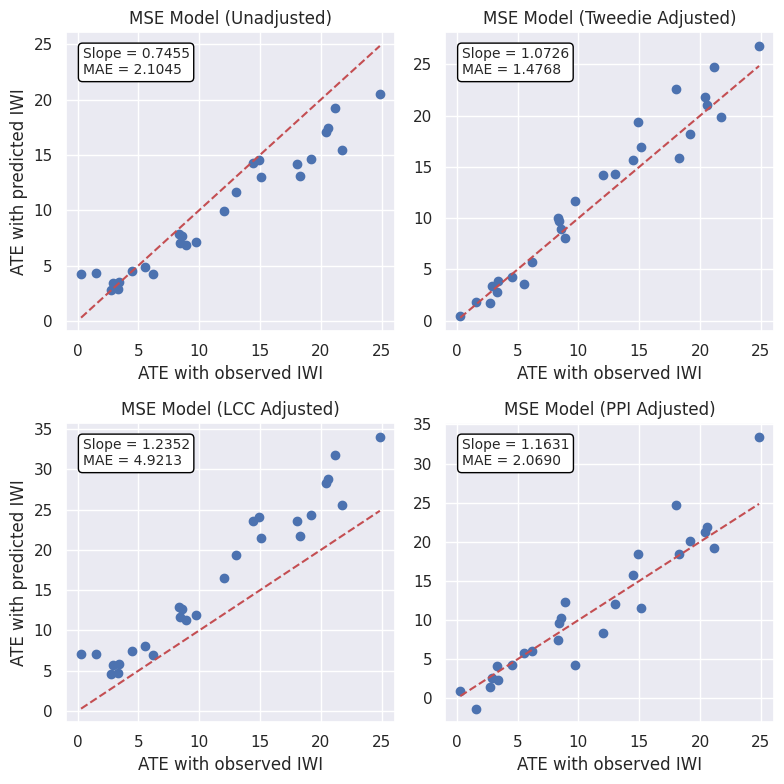

In [15]:
# Plot the ATEs
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(trials_df['ate'].values, trials_df['ate_hat'].values) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(trials_df['ate'].values, trials_df['ate_hat'].values, 1)
mae = mean_absolute_error(trials_df['ate'].values, trials_df['ate_hat'].values)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([trials_df['ate'].min(), trials_df['ate'].max()], [trials_df['ate'].min(), trials_df['ate'].max()], 'r--')
plt.xlabel('ATE with observed IWI')
plt.ylabel('ATE with predicted IWI')
plt.title('MSE Model (Unadjusted)')

plt.subplot(2, 2, 2)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(trials_df['ate'].values, trials_df['trial_ate_hat_tweedie'].values) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(trials_df['ate'].values, trials_df['trial_ate_hat_tweedie'].values, 1)
mae = mean_absolute_error(trials_df['ate'].values, trials_df['trial_ate_hat_tweedie'].values)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([trials_df['ate'].min(), trials_df['ate'].max()], [trials_df['ate'].min(), trials_df['ate'].max()], 'r--')
plt.xlabel('ATE with observed IWI')
#plt.ylabel('ATE with predicted IWI')
plt.title('MSE Model (Tweedie Adjusted)')

plt.subplot(2, 2, 3)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(trials_df['ate'].values, trials_df['trial_ate_hat_lcc'].values) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(trials_df['ate'].values, trials_df['trial_ate_hat_lcc'].values, 1)
mae = mean_absolute_error(trials_df['ate'].values, trials_df['trial_ate_hat_lcc'].values)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([trials_df['ate'].min(), trials_df['ate'].max()], [trials_df['ate'].min(), trials_df['ate'].max()], 'r--')
plt.xlabel('ATE with observed IWI')
plt.ylabel('ATE with predicted IWI')
plt.title('MSE Model (LCC Adjusted)')

plt.subplot(2, 2, 4)
# Plot points colored by funder (red for CH, blue for WB)
# Drop NaN values from the DataFrame
ppi_trials_df = trials_df.dropna(subset=['trial_ate_hat_ppi'])
plt.scatter(ppi_trials_df['ate'].values, ppi_trials_df['trial_ate_hat_ppi'].values) #, c=ppi_trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(ppi_trials_df['ate'].values, ppi_trials_df['trial_ate_hat_ppi'].values, 1)
mae = mean_absolute_error(ppi_trials_df['ate'].values, ppi_trials_df['trial_ate_hat_ppi'].values)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([ppi_trials_df['ate'].min(), trials_df['ate'].max()], [ppi_trials_df['ate'].min(), trials_df['ate'].max()], 'r--')
plt.xlabel('ATE with observed IWI')
#plt.ylabel('ATE with predicted IWI')
plt.title('MSE Model (PPI Adjusted)')

plt.tight_layout()
plt.show()

- In general, we get very few points that we can get "labeled data" for. This makes it hard to do PPI, but it is also a true representation since we often don't have more samples to take.
- Boxplot per treatment
- Simple confounders (urban/rural and survey)
- Sample overlap between treatments (for appendix)
- Rename test to downstream
- Consider opening with a Ratledge-like paper (i.e. a specific intervention)

## Use with confounders

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def get_treatment_probability(treated_df, control_df):
    
    treated_df['treated'] = True
    control_df['treated'] = False

    # Add rural confounder
    trial_df = pd.concat([treated_df, control_df], axis=0)

    X = trial_df[['country', 'rural', 'year']]
    y = trial_df['treated']

    # 2. Set up preprocessing for categorical variable
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), ['country'])  # drop first to avoid multicollinearity
        ],
        remainder='passthrough'  # keep 'rural' as is
    )

    # 3. Build pipeline: preprocess + logistic regression
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE+2))
    ])

    # 4. Fit the model
    model.fit(X, y)

    # 5. Get treatment probabilities (propensity scores)
    trial_df['p_of_T'] = model.predict_proba(X)[:, 1]
    
    return trial_df

In [17]:
def get_ates_of_trial_with_confounders(row, interventions_df, df_downstream):
    ad_sector_code = row['ad_sector_codes']
    funder = row['funder']

    intervention_df = interventions_df[(interventions_df['ad_sector_codes'] == ad_sector_code) & (interventions_df['funder'] == funder)]

    intervention_location_ids = intervention_df['project_location_id'].unique()

    intervention_dhs_link_df = interventions_dhs_link_df[interventions_dhs_link_df['project_location_id'].isin(intervention_location_ids)]
    valid_dhs_clusters = intervention_dhs_link_df[['cluster_id', 'years_since_intervention']].drop_duplicates()

    # The maximum and minimum years since the intervention start that we want to include to count as treated
    min_years = 3
    max_years = 8

    valid_dhs_cluster_ids = valid_dhs_clusters[valid_dhs_clusters['years_since_intervention'].between(min_years, max_years)]['cluster_id'].unique()
    treated_clusters_ixs = df_downstream['cluster_id'].isin(valid_dhs_cluster_ids)
    treated_df = df_downstream[treated_clusters_ixs]

    surveys_in_treated_df = treated_df['survey'].unique()
    control_clusters_ixs = (df_downstream['survey'].isin(surveys_in_treated_df)) & ~treated_clusters_ixs
    control_df = df_downstream[control_clusters_ixs]

    trial_df = get_treatment_probability(treated_df, control_df)

    # Compute weights
    trial_df['w_treated'] = trial_df['treated'] / trial_df['p_of_T']
    trial_df['w_control'] = (1 - trial_df['treated']) / (1 - trial_df['p_of_T'])

    # Compute weighted outcomes
    trial_df['weighted_iwi_treated'] = trial_df['w_treated'] * trial_df['iwi']
    trial_df['weighted_iwi_control'] = trial_df['w_control'] * trial_df['iwi']
    trial_df['weighted_iwi_hat_treated'] = trial_df['w_treated'] * trial_df['iwi_hat']
    trial_df['weighted_iwi_hat_control'] = trial_df['w_control'] * trial_df['iwi_hat']

    # Compute ATE
    ate_iptw = (trial_df['weighted_iwi_treated'] - trial_df['weighted_iwi_control']).mean()
    ate_hat_iptw = (trial_df['weighted_iwi_hat_treated'] - trial_df['weighted_iwi_hat_control']).mean()
    ate_hat_tweedie_iptw = ate_hat_iptw + res_std**2 * ((trial_df['w_control'] * trial_df['prediction_scores']).mean() - (trial_df['w_treated'] * trial_df['prediction_scores']).mean())

    row['ate_iptw'] = ate_iptw
    row['ate_hat_iptw'] = ate_hat_iptw
    row['ate_hat_tweedie_iptw'] = ate_hat_tweedie_iptw

    return row

# Get ATEs for all trials
trials_df = trials_df.progress_apply(get_ates_of_trial_with_confounders, axis=1, interventions_df=interventions_df, df_downstream=df_downstream)
trials_df

100%|██████████| 27/27 [00:01<00:00, 20.23it/s]


,funder,ad_sector_codes,ad_sector_names,ate,ate_hat,trial_ate_hat_tweedie,trial_ate_hat_lcc,trial_ate_hat_ppi,treated_count,control_count,ate_iptw,ate_hat_iptw,ate_hat_tweedie_iptw
0,CH,230,Energy Generation and Supply,14.927741,14.524057,19.356994,24.066689,18.435560,68,1245,-0.791715,-2.031512,-0.705531
1,CH,220,Communications,15.111552,12.997927,16.956648,21.537855,11.489225,194,885,1.547204,0.564912,2.756842
2,CH,210,Transport and Storage,19.176998,14.656670,18.213026,24.286430,20.126531,307,2736,6.459158,5.411317,4.894152
3,CH,110,Education,13.028107,11.662964,14.279178,19.325792,12.110084,312,4001,7.194982,6.063204,9.013047
4,CH,150,Government and Civil Society,20.557508,17.389824,21.001185,28.815329,21.839137,369,4407,12.082126,6.354966,9.973232
5,CH,320,"Industry, Mining, Construction",21.701686,15.431425,19.912010,25.570217,NaN,11,299,-1.186885,2.388850,6.848069
6,CH,310,"Agriculture, Forestry and Fishing",5.546507,4.885996,3.541975,8.096205,5.748891,198,1741,5.431195,1.847555,1.102621
7,CH,120,Health,20.439427,17.046370,21.780352,28.246216,21.282828,636,6095,9.480577,7.428132,10.370240
8,CH,520,Developmental Food Aid/Food Security Assistance,18.019459,14.208677,22.612663,23.544096,24.745432,31,445,3.615400,3.024581,9.762048
9,CH,140,Water Supply and Sanitation,18.289454,13.125183,15.898976,21.748722,18.473894,143,1488,0.562020,0.508479,-5.335507


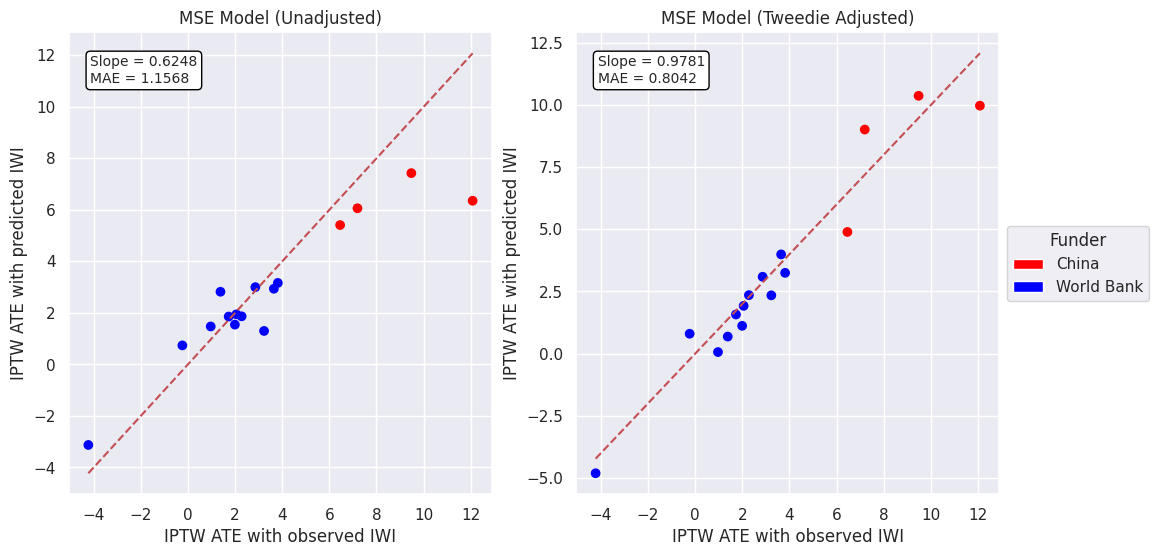

In [18]:
from matplotlib.patches import Patch

trials_df_i = trials_df[trials_df['treated_count'] > 200].copy()

# Plot the ATEs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(trials_df_i['ate_iptw'].values, trials_df_i['ate_hat_iptw'].values, c=trials_df_i['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(trials_df_i['ate_iptw'].values, trials_df_i['ate_hat_iptw'].values, 1)
mae = mean_absolute_error(trials_df_i['ate_iptw'].values, trials_df_i['ate_hat_iptw'].values)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([trials_df_i['ate_iptw'].min(), trials_df_i['ate_iptw'].max()], [trials_df_i['ate_iptw'].min(), trials_df_i['ate_iptw'].max()], 'r--')
plt.xlabel('IPTW ATE with observed IWI')
plt.ylabel('IPTW ATE with predicted IWI')
plt.title('MSE Model (Unadjusted)')

plt.subplot(1, 2, 2)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(trials_df_i['ate_iptw'].values, trials_df_i['ate_hat_tweedie_iptw'].values, c=trials_df_i['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(trials_df_i['ate_iptw'].values, trials_df_i['ate_hat_tweedie_iptw'].values, 1)
mae = mean_absolute_error(trials_df_i['ate_iptw'].values, trials_df_i['ate_hat_tweedie_iptw'].values)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([trials_df_i['ate_iptw'].min(), trials_df_i['ate_iptw'].max()], [trials_df_i['ate_iptw'].min(), trials_df_i['ate_iptw'].max()], 'r--')
plt.xlabel('IPTW ATE with observed IWI')
plt.ylabel('IPTW ATE with predicted IWI')
plt.title('MSE Model (Tweedie Adjusted)')
legend_elements = [
    Patch(facecolor='red', label='China'),
    Patch(facecolor='blue', label='World Bank')
]
plt.legend(handles=legend_elements, title='Funder', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [19]:
trials_df_i.sort_values('ate_iptw', ascending=False)

,funder,ad_sector_codes,ad_sector_names,ate,ate_hat,trial_ate_hat_tweedie,trial_ate_hat_lcc,trial_ate_hat_ppi,treated_count,control_count,ate_iptw,ate_hat_iptw,ate_hat_tweedie_iptw
4,CH,150,Government and Civil Society,20.557508,17.389824,21.001185,28.815329,21.839137,369,4407,12.082126,6.354966,9.973232
7,CH,120,Health,20.439427,17.046370,21.780352,28.246216,21.282828,636,6095,9.480577,7.428132,10.370240
3,CH,110,Education,13.028107,11.662964,14.279178,19.325792,12.110084,312,4001,7.194982,6.063204,9.013047
2,CH,210,Transport and Storage,19.176998,14.656670,18.213026,24.286430,20.126531,307,2736,6.459158,5.411317,4.894152
30,WB,110,Education,8.585682,7.625908,8.923036,12.636300,10.291634,1258,4562,3.815740,3.164372,3.248871
27,WB,140,Water Supply and Sanitation,8.442053,7.057859,9.765134,11.695031,9.580396,2041,5357,3.647108,2.938673,3.991973
31,WB,120,Health,3.416949,3.502794,3.900882,5.804209,2.299826,1398,4190,3.230740,1.299823,2.344566
21,WB,230,Energy Generation and Supply,8.299489,7.805946,10.043079,12.934628,7.419072,1275,4923,2.861769,3.000433,3.091769
23,WB,160,Other Social Infrastructure and Services,6.168825,4.210497,5.756457,6.976888,6.040890,1845,4686,2.279558,1.867525,2.352717
25,WB,310,"Agriculture, Forestry and Fishing",3.338528,2.838259,2.783252,4.703058,4.137060,1741,4890,2.055936,1.944139,1.921892


In [20]:
# Pivot the data so that each funder becomes a column
pivot_df = trials_df.pivot_table(index='ad_sector_names', columns='funder', values='ate_iptw')

# Calculate the difference: CH - WB
pivot_df['diff_CH_WB'] = pivot_df['CH'] - pivot_df['WB']

# Optional: Reset index if you want a flat DataFrame
result_df = pivot_df.reset_index()

# Display the result
result_df[['ad_sector_names', 'diff_CH_WB']].sort_values('diff_CH_WB', ascending=False)

funder,ad_sector_names,diff_CH_WB
8,Government and Civil Society,10.352507
9,Health,6.249837
14,Transport and Storage,5.491763
4,Education,3.379243
0,"Agriculture, Forestry and Fishing",3.375259
2,Communications,1.783206
12,Other Social Infrastructure and Services,0.665379
15,Water Supply and Sanitation,-3.085089
10,"Industry, Mining, Construction",-3.179670
6,Energy Generation and Supply,-3.653484


## Bootstrap on downstream data

In [ ]:
N_BOOTSTRAP_SAMPLES = 1000

def get_ates_of_trial_with_confounders_bootstrap(row, interventions_df, df_downstream):
    ad_sector_code = row['ad_sector_codes']
    funder = row['funder']

    intervention_df = interventions_df[(interventions_df['ad_sector_codes'] == ad_sector_code) & (interventions_df['funder'] == funder)]

    intervention_location_ids = intervention_df['project_location_id'].unique()

    intervention_dhs_link_df = interventions_dhs_link_df[interventions_dhs_link_df['project_location_id'].isin(intervention_location_ids)]
    valid_dhs_clusters = intervention_dhs_link_df[['cluster_id', 'years_since_intervention']].drop_duplicates()

    # The maximum and minimum years since the intervention start that we want to include to count as treated
    min_years = 3
    max_years = 8

    valid_dhs_cluster_ids = valid_dhs_clusters[valid_dhs_clusters['years_since_intervention'].between(min_years, max_years)]['cluster_id'].unique()
    treated_clusters_ixs = df_downstream['cluster_id'].isin(valid_dhs_cluster_ids)
    treated_df = df_downstream[treated_clusters_ixs]

    surveys_in_treated_df = treated_df['survey'].unique()
    control_clusters_ixs = (df_downstream['survey'].isin(surveys_in_treated_df)) & ~treated_clusters_ixs
    control_df = df_downstream[control_clusters_ixs]

    #trial_df = get_treatment_probability(treated_df, control_df)

    # Compute weights
    #trial_df['w_treated'] = trial_df['treated'] / trial_df['p_of_T']
    #trial_df['w_control'] = (1 - trial_df['treated']) / (1 - trial_df['p_of_T'])

    # Bootstrap sampling
    bootstrap_ate_iptws = []
    bootstrap_ate_hat_iptws = []
    bootstrap_ate_hat_tweedie_iptws = []

    for _ in range(N_BOOTSTRAP_SAMPLES):
        # Sample with replacement
        treated_bootstrap_sample = treated_df.sample(frac=1, replace=True)
        control_bootstrap_sample = control_df.sample(frac=1, replace=True)

        bootstrap_sample = get_treatment_probability(treated_bootstrap_sample, control_bootstrap_sample)

        # Compute weights
        bootstrap_sample['w_treated'] = bootstrap_sample['treated'] / bootstrap_sample['p_of_T']
        bootstrap_sample['w_control'] = (1 - bootstrap_sample['treated']) / (1 - bootstrap_sample['p_of_T'])

        # Compute weighted outcomes
        bootstrap_sample['weighted_iwi_treated'] = bootstrap_sample['w_treated'] * bootstrap_sample['iwi']
        bootstrap_sample['weighted_iwi_control'] = bootstrap_sample['w_control'] * bootstrap_sample['iwi']
        bootstrap_sample['weighted_iwi_hat_treated'] = bootstrap_sample['w_treated'] * bootstrap_sample['iwi_hat']
        bootstrap_sample['weighted_iwi_hat_control'] = bootstrap_sample['w_control'] * bootstrap_sample['iwi_hat']

        # Compute ATE
        ate_iptw = (bootstrap_sample['weighted_iwi_treated'] - bootstrap_sample['weighted_iwi_control']).mean()
        ate_hat_iptw = (bootstrap_sample['weighted_iwi_hat_treated'] - bootstrap_sample['weighted_iwi_hat_control']).mean()
        ate_hat_tweedie_iptw = ate_hat_iptw + res_std**2 * ((bootstrap_sample['w_control'] * bootstrap_sample['prediction_scores']).mean() - (bootstrap_sample['w_treated'] * bootstrap_sample['prediction_scores']).mean())

        bootstrap_ate_iptws.append(ate_iptw)
        bootstrap_ate_hat_iptws.append(ate_hat_iptw)
        bootstrap_ate_hat_tweedie_iptws.append(ate_hat_tweedie_iptw)

    row['bootstrap_ate_iptws'] = bootstrap_ate_iptws
    row['bootstrap_ate_hat_iptws'] = bootstrap_ate_hat_iptws
    row['bootstrap_ate_hat_tweedie_iptws'] = bootstrap_ate_hat_tweedie_iptws

    return row

# Get ATEs for all trials
trials_df = trials_df.progress_apply(get_ates_of_trial_with_confounders_bootstrap, axis=1, interventions_df=interventions_df, df_downstream=df_downstream)
trials_df

 26%|██▌       | 7/27 [02:44<08:09, 24.47s/it]

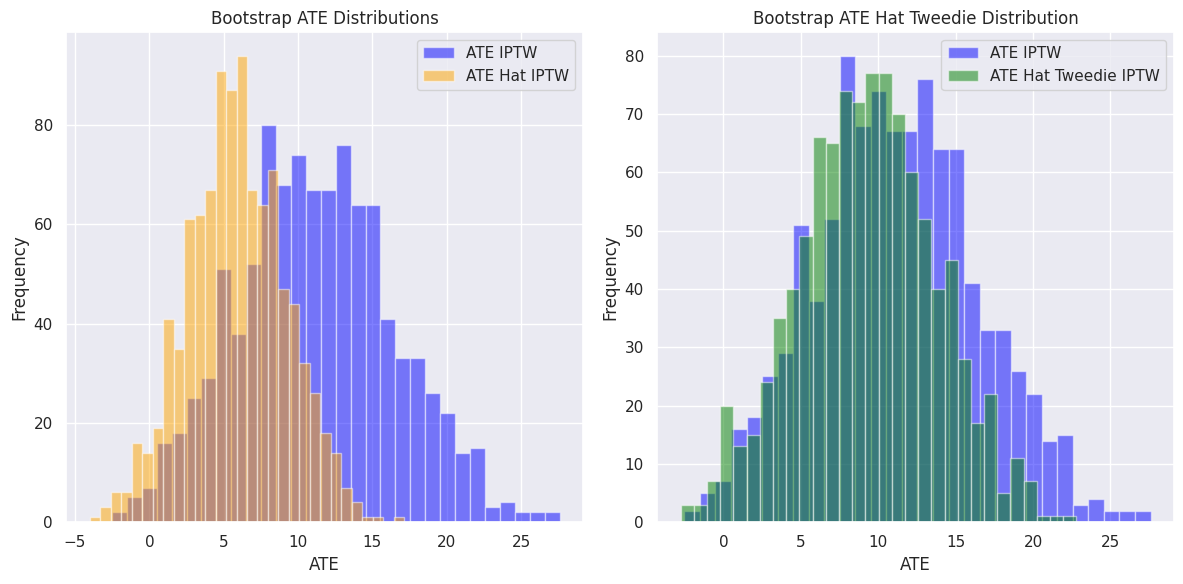

In [ ]:
trial_df = trials_df.iloc[4]

bootstrap_ate_iptws = np.array(trial_df['bootstrap_ate_iptws'])
bootstrap_ate_hat_iptws = np.array(trial_df['bootstrap_ate_hat_iptws'])
bootstrap_ate_hat_tweedie_iptws = np.array(trial_df['bootstrap_ate_hat_tweedie_iptws'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(bootstrap_ate_iptws, bins=30, alpha=0.5, label='ATE IPTW', color='blue')
plt.hist(bootstrap_ate_hat_iptws, bins=30, alpha=0.5, label='ATE Hat IPTW', color='orange')
plt.xlabel('ATE')
plt.ylabel('Frequency')
plt.title('Bootstrap ATE Distributions')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(bootstrap_ate_iptws, bins=30, alpha=0.5, label='ATE IPTW', color='blue')
plt.hist(bootstrap_ate_hat_tweedie_iptws, bins=30, alpha=0.5, label='ATE Hat Tweedie IPTW', color='green')
plt.xlabel('ATE')
plt.ylabel('Frequency')
plt.title('Bootstrap ATE Hat Tweedie Distribution')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
trials_df[['ate_iptw', 'bootstrap_ate_hat_iptws', 'bootstrap_ate_hat_tweedie_iptws']].head(10)

,ate_iptw,bootstrap_ate_hat_iptws,bootstrap_ate_hat_tweedie_iptws
0,-0.791715,"[-5.891386629688694, -3.948910483904104, -1.79...","[-9.311325296498673, -1.7920346749956617, 2.36..."
1,1.547204,"[-0.5508404702747416, 1.2037856364172737, 1.56...","[1.8012964638882962, 2.3081646901826507, 3.498..."
2,6.459158,"[5.925160561386996, 4.795836199307116, 5.21746...","[4.992000655763504, 4.507266043430976, 3.26855..."
3,7.194982,"[-0.23426033207005845, 5.615812793983899, 14.8...","[0.9489120716119215, 9.380108875525865, 17.870..."
4,12.082126,"[3.752168922167799, 9.015602669681956, 5.38912...","[6.683553439847209, 12.807594555622101, 9.4104..."
5,-1.186885,"[4.853131343652615, 10.520387405258706, 9.0954...","[12.109586196205374, 16.417671160586465, 15.91..."
6,5.431195,"[0.08116804579558358, 2.7694155056219136, 3.56...","[-1.2461820417301914, 2.5202967812309174, 1.68..."
7,9.480577,"[8.791189680712135, 9.310200404822506, 9.01508...","[12.94160721888105, 11.78435371480088, 12.1138..."
8,3.615400,"[2.162459934087882, 0.3633938019103876, 15.753...","[10.613277208072766, 2.5417009559845614, 26.02..."
9,0.562020,"[-5.457655421714759, 0.7135646056507436, -3.22...","[-12.445591730462146, -10.318049301727783, -12..."


In [ ]:
bootstrap_ate_iptws = np.stack(trials_df['bootstrap_ate_iptws'].values)[trials_df['treated_count'] > 200]
bootstrap_ate_hat_iptws = np.stack(trials_df['bootstrap_ate_hat_iptws'].values)[trials_df['treated_count'] > 200]
bootstrap_ate_hat_tweedie_iptws = np.stack(trials_df['bootstrap_ate_hat_tweedie_iptws'].values)[trials_df['treated_count'] > 200]

delta_b = bootstrap_ate_iptws - bootstrap_ate_hat_iptws
delta_b_tweedies = bootstrap_ate_iptws - bootstrap_ate_hat_tweedie_iptws

alpha = 0.1
lower_bound = np.percentile(delta_b, 100 * alpha / 2, axis=1)
upper_bound = np.percentile(delta_b, 100 * (1 - alpha / 2), axis=1)

lower_bound_tweedies = np.percentile(delta_b_tweedies, 100 * alpha / 2, axis=1)
upper_bound_tweedies = np.percentile(delta_b_tweedies, 100 * (1 - alpha / 2), axis=1)

covered = (lower_bound <= 0) & (upper_bound >= 0)
covered_tweedies = (lower_bound_tweedies <= 0) & (upper_bound_tweedies >= 0)

width = upper_bound - lower_bound
width_tweedies = upper_bound_tweedies - lower_bound_tweedies

print('Alpha:', alpha)
print('Covered hat:', covered.mean())
print('Covered hat tweedie:', covered_tweedies.mean())
print('Width hat:', width.mean())
print('Width hat tweedie:', width_tweedies.mean())

Alpha: 0.1
Covered hat: 0.75
Covered hat tweedie: 0.9375
Width hat: 2.6575914389974287
Width hat tweedie: 3.992310924744517


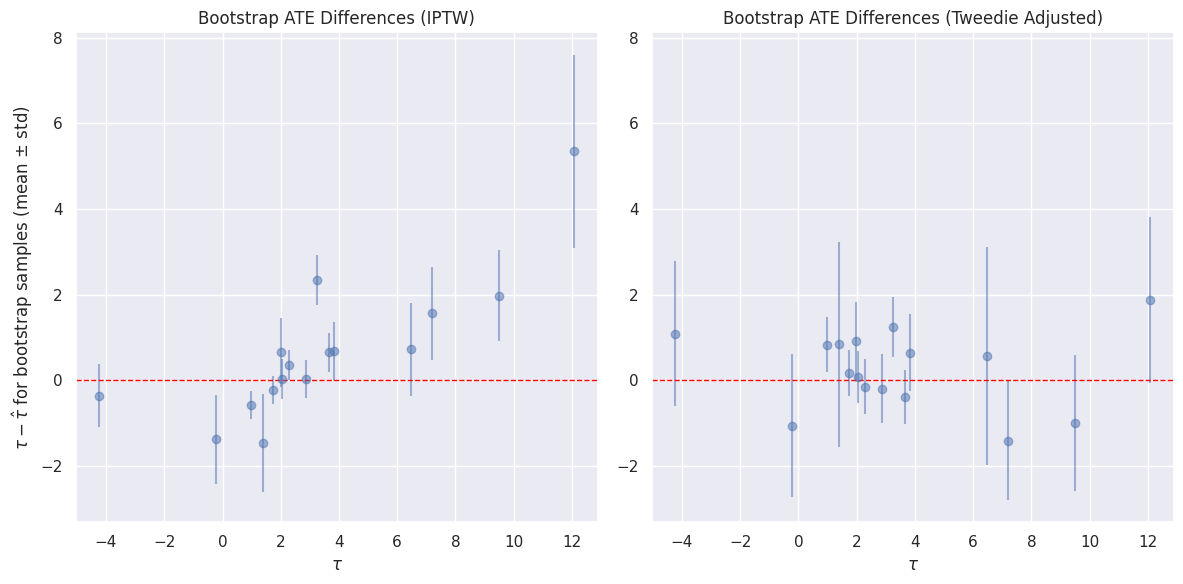

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1, sharey=plt.subplot(1, 2, 2))
plt.errorbar(trials_df['ate_iptw'].values[trials_df['treated_count'] > 200], delta_b.mean(axis=1), yerr=delta_b.std(axis=1), fmt='o', alpha=0.5, label='Delta B')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\tau - \hat{\tau}$ for bootstrap samples (mean $\pm$ std)')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')
plt.title('Bootstrap ATE Differences (IPTW)')

plt.subplot(1, 2, 2)
plt.errorbar(trials_df['ate_iptw'].values[trials_df['treated_count'] > 200], delta_b_tweedies.mean(axis=1), yerr=delta_b_tweedies.std(axis=1), fmt='o', alpha=0.5, label='Delta B')
plt.xlabel(r'$\tau$')
#plt.ylabel(r'$\tau - \hat{\tau}$ for bootstrap samples (mean $\pm$ std)')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')
plt.title('Bootstrap ATE Differences (Tweedie Adjusted)')

plt.tight_layout()
plt.show()


#, delta_b_tweedies.mean(axis=1)

In [ ]:
from scipy.stats import pearsonr, spearmanr

r, p_value = pearsonr(trials_df['ate_iptw'].values[trials_df['treated_count'] > 200], delta_b.mean(axis=1))
print("Correlation coefficient:", r)
print("p-value:", p_value)

r_tweedies, p_value_tweedies = pearsonr(trials_df['ate_iptw'].values[trials_df['treated_count'] > 200], delta_b_tweedies.mean(axis=1))
print("Correlation coefficient (Tweedie):", r_tweedies)
print("p-value (Tweedie):", p_value_tweedies)

spearmanr_r, spearmanr_p_value = spearmanr(trials_df['ate_iptw'].values[trials_df['treated_count'] > 200], delta_b.mean(axis=1))
print("Spearman's rank correlation coefficient:", spearmanr_r)
print("Spearman's p-value:", spearmanr_p_value)

spearmanr_r_tweedies, spearmanr_p_value_tweedies = spearmanr(trials_df['ate_iptw'].values[trials_df['treated_count'] > 200], delta_b_tweedies.mean(axis=1))
print("Spearman's rank correlation coefficient (Tweedie):", spearmanr_r_tweedies)
print("Spearman's p-value (Tweedie):", spearmanr_p_value_tweedies)

Correlation coefficient: 0.8138479829866275
p-value: 0.00012499178853329977
Correlation coefficient (Tweedie): -0.05952171817583379
p-value (Tweedie): 0.8266758704768444
Spearman's rank correlation coefficient: 0.8941176470588235
Spearman's p-value: 3.0113099296374175e-06
Spearman's rank correlation coefficient (Tweedie): -0.15
Spearman's p-value (Tweedie): 0.5792486306642535


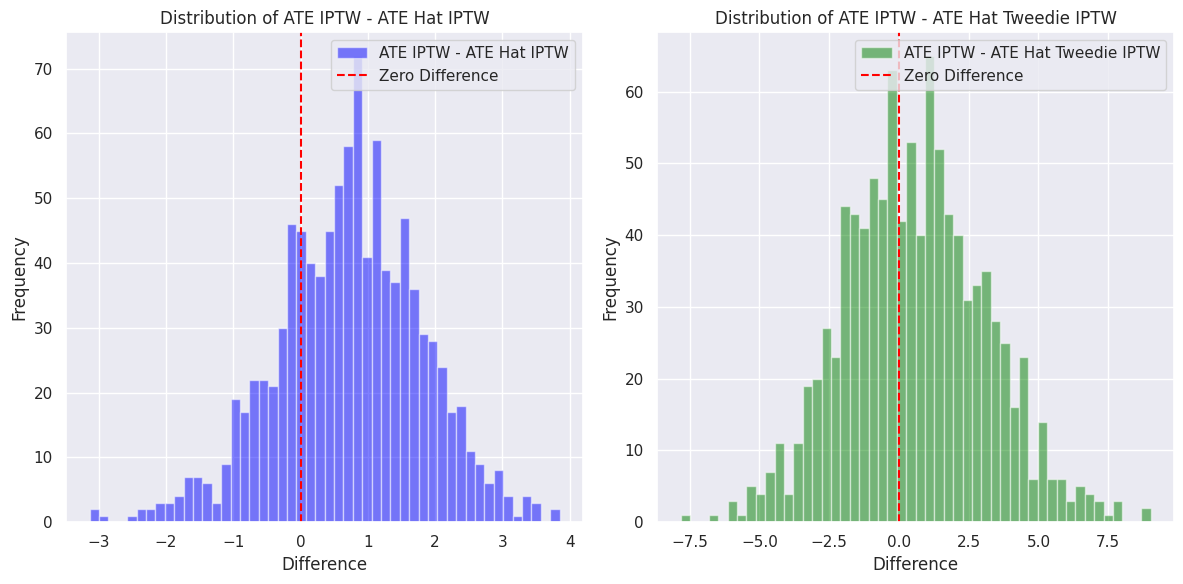

In [ ]:
i = 2

# Histogram of the differences
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(delta_b[i], bins=50, alpha=0.5, label='ATE IPTW - ATE Hat IPTW', color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Difference')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of ATE IPTW - ATE Hat IPTW')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(delta_b_tweedies[i], bins=50, alpha=0.5, label='ATE IPTW - ATE Hat Tweedie IPTW', color='green')
plt.axvline(0, color='red', linestyle='--', label='Zero Difference')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of ATE IPTW - ATE Hat Tweedie IPTW')
plt.legend()
plt.tight_layout()
plt.show()

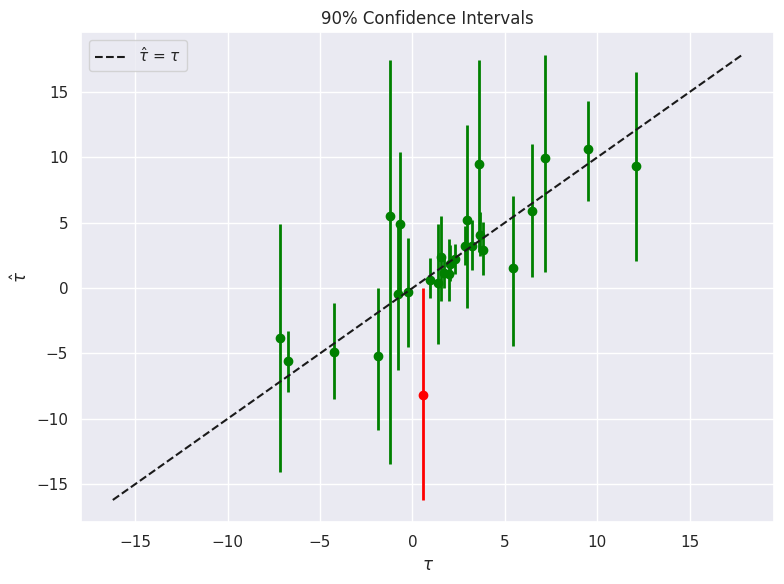

In [ ]:
trials_df_i  = trials_df.copy()

# Z-score for 90% confidence interval
z = 1.645

# Calculate mean, SE, and CI bounds
trials_df_i['hat_mean'] = trials_df_i['bootstrap_ate_hat_tweedie_iptws'].apply(np.mean)
trials_df_i['hat_se'] = trials_df_i['bootstrap_ate_hat_tweedie_iptws'].apply(lambda y: np.std(y, ddof=1))
trials_df_i['hat_lower'] = trials_df_i['hat_mean'] - z * trials_df_i['hat_se']
trials_df_i['hat_upper'] = trials_df_i['hat_mean'] + z * trials_df_i['hat_se']

# Compute 90% CI (5th and 95th percentiles)
#trials_df_i['hat_lower'] = trials_df_i['bootstrap_ate_hat_tweedie_iptws'].apply(lambda lst: np.percentile(lst, 5))
#trials_df_i['hat_upper'] = trials_df_i['bootstrap_ate_hat_tweedie_iptws'].apply(lambda lst: np.percentile(lst, 95))

# Check if x falls within the CI
trials_df_i['crosses_y_equals_x'] = trials_df_i.apply(lambda row: row['hat_lower'] <= row['ate_iptw'] <= row['hat_upper'], axis=1)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

for _, row in trials_df_i.iterrows():
    color = 'green' if row['crosses_y_equals_x'] else 'red'
    ax.vlines(row['ate_iptw'], row['hat_lower'], row['hat_upper'], color=color, linewidth=2)
    # Optionally, add median marker
    median = np.median(row['bootstrap_ate_hat_tweedie_iptws'])
    ax.plot(row['ate_iptw'], median, 'o', color=color)

# Plot 45° line
lims = [
    min(trials_df_i['ate_iptw'].min(), trials_df_i['hat_lower'].min()),
    max(trials_df_i['ate_iptw'].max(), trials_df_i['hat_upper'].max())
]
ax.plot(lims, lims, 'k--', label=r'$\hat{\tau}$ = $\tau$')

ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$\hat{\tau}$")
ax.set_title("90% Confidence Intervals")
ax.legend()
plt.tight_layout()
plt.show()
